In [85]:
from lime.lime_text import LimeTextExplainer

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

import random
import gluonnlp as nlp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

from tqdm import tqdm
import copy
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, accuracy_score
from sklearn.model_selection import train_test_split                                                      


#kobert
from kobert.utils import get_tokenizer
from kobert.pytorch_kobert import get_pytorch_kobert_model

#transformers
from transformers import AdamW
from transformers.optimization import get_cosine_schedule_with_warmup
#GPU 사용
device = torch.device("cuda:0")
#BERT 모델, Vocabulary 불러오기
bertmodel, vocab = get_pytorch_kobert_model()


using cached model. /workspace/LIME/.cache/kobert_v1.zip
using cached model. /workspace/LIME/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [86]:
seed = 42

DATA = "steam"

train_writer = SummaryWriter('./runs/' + DATA +'/LIME/train')
valid_writer = SummaryWriter('./runs/' + DATA +'/LIME/valid')
test_writer = SummaryWriter('./runs/' + DATA +'/LIME/test')

In [87]:
steam=pd.DataFrame()
sentences=[]
labels=[]

file = open("/workspace/data/steam.txt", "r")
for line in file:
    lines=line.split('\t')
    labels.append(int(lines[0]))
    sentences.append(lines[1].strip('\n'))

steam['sentence']=sentences
steam['label']=labels

print('결측치 확인 : \n', steam.isnull().sum())
print('중복값 체크 : ', steam.duplicated().sum(), '\n')

train, test = train_test_split(steam, test_size=0.1, random_state=seed) #훈련데이터 셋

test.reset_index(inplace=True, drop=True)
test.to_csv("/workspace/data/steam_test.csv", index=False)


결측치 확인 : 
 sentence    0
label       0
dtype: int64
중복값 체크 :  0 



In [88]:
train_data = []

for sentence, label in zip(train['sentence'], train['label']):
    train_data.append([sentence, label])

train_data, validation_data = train_test_split(train_data, test_size=0.1, random_state=seed) #훈련데이터 셋


In [89]:
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # torch 
torch.cuda.manual_seed(seed)# torch 
torch.cuda.manual_seed_all(seed)

class BERTDataset(Dataset):
    def __init__(self, dataset, sent_idx, label_idx, bert_tokenizer, max_len,
                 pad, pair):
        transform = nlp.data.BERTSentenceTransform(
            bert_tokenizer, max_seq_length=max_len, pad=pad, pair=pair)

        self.sentences = [transform([i[sent_idx]]) for i in dataset]
        self.labels = [np.int32(i[label_idx]) for i in dataset]

    def __getitem__(self, i):
        return (self.sentences[i] + (self.labels[i], ))

    def __len__(self):
        return (len(self.labels))

max_len = 128
batch_size = 64
warmup_ratio = 0.1
num_epochs = 10
max_grad_norm = 1
log_interval = 2000
learning_rate = 5e-5

#토큰화
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)

train_data = BERTDataset(train_data, 0, 1, tok, max_len, True, False) #train_data 리스트 0번째가 sent / 1은 label
validation_data = BERTDataset(validation_data, 0, 1, tok, max_len, True, False)

train_dataloader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, num_workers=5)
valid_dataloader = torch.utils.data.DataLoader(validation_data, batch_size=batch_size, num_workers=5)

class BERTClassifier(nn.Module):
    def __init__(self,
                 bert,
                 hidden_size = 768,
                 num_classes=2,   ##클래스 수 조정##
                 dr_rate=None,
                 params=None):
        super(BERTClassifier, self).__init__()
        self.bert = bert
        self.dr_rate = dr_rate
        with open('/workspace/LIME/.cache/kobert_from_pretrained/config.json') as f:
            json_object = json.load(f)
        #self.config = Config(json_object)
        #self.base_model_prefix = "bert"
        
        #self.device = device
        #self.get_input_embeddings = bertmodel.get_input_embeddings()
        

        self.classifier = nn.Linear(hidden_size , num_classes)
        if dr_rate:
            self.dropout = nn.Dropout(p=dr_rate)
    
    def gen_attention_mask(self, token_ids, valid_length):
        attention_mask = torch.zeros_like(token_ids)
        for i, v in enumerate(valid_length):
            attention_mask[i][:v] = 1
        return attention_mask.float()

    def forward(self, token_ids, valid_length, segment_ids):
        attention_mask = self.gen_attention_mask(token_ids, valid_length)
        
        _, pooler = self.bert(input_ids = token_ids, token_type_ids = segment_ids.long(), attention_mask = attention_mask.float().to(token_ids.device))
        if self.dr_rate:
            out = self.dropout(pooler)

#        return pooler
        return self.classifier(out)

#BERT 모델 불러오기
model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)

#optimizer와 schedule 설정
no_decay = ['bias', 'LayerNorm.weight']
optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': 0.01},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]
optimizer = AdamW(optimizer_grouped_parameters, lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()
#loss_fn = nn.BCEWithLogitsLoss()
#loss_fn = nn.BCELoss()

t_total = len(train_dataloader) * num_epochs
warmup_step = int(t_total * warmup_ratio)

scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps=warmup_step, num_training_steps=t_total)

#정확도 측정을 위한 함수 정의
def calc_accuracy(X,Y):#out,label
    max_vals, max_indices = torch.max(X, 1)
    train_acc = (max_indices == Y).sum().data.cpu().numpy()/max_indices.size()[0]
    return train_acc
    

using cached model. /workspace/LIME/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


In [6]:
model_result=[]
#train_loss_list = []
#train_acc_list = []
#valid_loss_list = []
#valid_acc_list = []

random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed) # torch 
torch.cuda.manual_seed(seed)# torch 
torch.cuda.manual_seed_all(seed)

for e in range(num_epochs):
    train_acc = 0.0
    test_acc = 0.0
    model.train()
    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(train_dataloader)):
        optimizer.zero_grad()
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length = valid_length

        label = label.long().to(device)
        out = model(token_ids, valid_length, segment_ids)
        loss = loss_fn(out, label)
        loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)
        optimizer.step()    
        scheduler.step()    #Update learning rate schedule
        train_acc += calc_accuracy(out, label)
        if batch_id % log_interval == 0:
            print("epoch {} batch id {} loss {} train acc {}".format(e+1, batch_id+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))

    print("epoch {} loss {} train acc {}".format(e+1, loss.data.cpu().numpy(), train_acc / (batch_id+1)))
    train_writer.add_scalar("Loss/train", loss.data.cpu().numpy(), e+1)
    train_writer.add_scalar("Accuracy/train", train_acc/(batch_id+1), e+1)
    
    with torch.no_grad():
        model.eval()
        for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(valid_dataloader)):
            token_ids = token_ids.long().to(device)
            segment_ids = segment_ids.long().to(device)
            valid_length= valid_length
            label = label.long().to(device)
            
            out = model(token_ids, valid_length, segment_ids)
            loss2 = loss_fn(out, label)
            test_acc += calc_accuracy(out, label)
        print("epoch {} loss {} test acc {}".format(e+1, loss2.data.cpu().numpy(), test_acc / (batch_id+1)))
        valid_writer.add_scalar("Accuracy/valid", test_acc/(batch_id+1), e+1)
        valid_writer.add_scalar("Loss/valid", loss2.data.cpu().numpy(), e+1)

        #모델 저장하기
        model_path = "/workspace/model/KoBERT/steam/" + str(e+1) + "_0816.pt"
        torch.save(model.state_dict(), model_path)

valid_writer.close()
train_writer.close()


  0%|          | 1/1266 [00:00<18:30,  1.14it/s]

epoch 1 batch id 1 loss 0.7243950366973877 train acc 0.453125


100%|██████████| 1266/1266 [15:09<00:00,  1.39it/s]


epoch 1 loss 0.439706951379776 train acc 0.7361176935229068


100%|██████████| 141/141 [00:30<00:00,  4.60it/s]


epoch 1 loss 0.5037440657615662 test acc 0.8047429078014184


  0%|          | 1/1266 [00:00<17:18,  1.22it/s]

epoch 2 batch id 1 loss 0.5187364816665649 train acc 0.703125


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 2 loss 0.3356657922267914 train acc 0.8229314770932069


100%|██████████| 141/141 [00:31<00:00,  4.54it/s]


epoch 2 loss 0.6023536920547485 test acc 0.8175531914893618


  0%|          | 1/1266 [00:00<17:15,  1.22it/s]

epoch 3 batch id 1 loss 0.46257078647613525 train acc 0.828125


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 3 loss 0.23815187811851501 train acc 0.8757726105845183


100%|██████████| 141/141 [00:30<00:00,  4.58it/s]


epoch 3 loss 0.7942685484886169 test acc 0.8072473404255319


  0%|          | 1/1266 [00:00<16:53,  1.25it/s]

epoch 4 batch id 1 loss 0.3701239228248596 train acc 0.875


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 4 loss 0.2112838476896286 train acc 0.9122111966824644


100%|██████████| 141/141 [00:30<00:00,  4.57it/s]


epoch 4 loss 0.640751302242279 test acc 0.8206338652482269


  0%|          | 1/1266 [00:00<17:19,  1.22it/s]

epoch 5 batch id 1 loss 0.1703774333000183 train acc 0.921875


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 5 loss 0.08035454154014587 train acc 0.9387021129541864


100%|██████████| 141/141 [00:30<00:00,  4.55it/s]


epoch 5 loss 0.7035333514213562 test acc 0.80489804964539


  0%|          | 1/1266 [00:00<17:15,  1.22it/s]

epoch 6 batch id 1 loss 0.2520228624343872 train acc 0.90625


100%|██████████| 1266/1266 [13:01<00:00,  1.62it/s]


epoch 6 loss 0.13940569758415222 train acc 0.9587702409162716


100%|██████████| 141/141 [00:30<00:00,  4.56it/s]


epoch 6 loss 0.8322716951370239 test acc 0.8194370567375887


  0%|          | 1/1266 [00:00<17:50,  1.18it/s]

epoch 7 batch id 1 loss 0.06636637449264526 train acc 0.984375


100%|██████████| 1266/1266 [13:01<00:00,  1.62it/s]


epoch 7 loss 0.17753219604492188 train acc 0.9720181674565561


100%|██████████| 141/141 [00:30<00:00,  4.57it/s]


epoch 7 loss 1.0882468223571777 test acc 0.8231382978723404


  0%|          | 1/1266 [00:00<16:44,  1.26it/s]

epoch 8 batch id 1 loss 0.010313128121197224 train acc 1.0


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 8 loss 0.005790011025965214 train acc 0.9790679304897314


100%|██████████| 141/141 [00:30<00:00,  4.56it/s]


epoch 8 loss 1.060509204864502 test acc 0.8216533687943263


  0%|          | 1/1266 [00:00<18:19,  1.15it/s]

epoch 9 batch id 1 loss 0.1356198787689209 train acc 0.96875


100%|██████████| 1266/1266 [13:01<00:00,  1.62it/s]


epoch 9 loss 0.0032052528113126755 train acc 0.9845601303317536


100%|██████████| 141/141 [00:30<00:00,  4.56it/s]


epoch 9 loss 1.1889140605926514 test acc 0.8226285460992907


  0%|          | 1/1266 [00:00<16:51,  1.25it/s]

epoch 10 batch id 1 loss 0.004487995989620686 train acc 1.0


100%|██████████| 1266/1266 [13:00<00:00,  1.62it/s]


epoch 10 loss 0.047393057495355606 train acc 0.9872432859399684


100%|██████████| 141/141 [00:30<00:00,  4.56it/s]


epoch 10 loss 1.2317899465560913 test acc 0.822406914893617


In [8]:
def roc_curve_plot(y_test , pred_proba_c1):
    # 임곗값에 따른 FPR, TPR 값을 반환 받음. 
    fprs , tprs , thresholds = roc_curve(y_test, pred_proba_c1)

    # ROC Curve를 plot 곡선으로 그림. 
    plt.plot(fprs , tprs, label='ROC')
    # 가운데 대각선 직선을 그림. 
    plt.plot([0, 1], [0, 1], 'k--', label='Random')
  
    # FPR X 축의 Scale을 0.1 단위로 변경, X,Y 축명 설정등   
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.xlabel('FPR( 1 - Sensitivity )')
    plt.ylabel('TPR( Recall )')
    plt.legend()
    plt.show()

using cached model. /workspace/LIME/.cache/kobert_news_wiki_ko_cased-1087f8699e.spiece


100%|██████████| 10000/10000 [02:07<00:00, 78.17it/s]


0 epoch [오류 분석]
[[4220  767]
 [1049 3964]]
0.8184
              precision    recall  f1-score   support

          부정       0.80      0.85      0.82      4987
          긍정       0.84      0.79      0.81      5013

    accuracy                           0.82     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.82      0.82      0.82     10000

AUC : 81.85


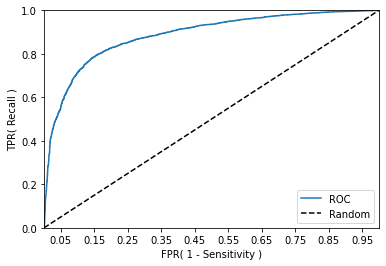

In [28]:

def softmax(a):
    exp_a = np.exp(a)
    sum_exp_a = np.sum(exp_a)
    y=exp_a / sum_exp_a
    return y

#validation_data
true_label=[]
tokenizer = get_tokenizer()
tok = nlp.data.BERTSPTokenizer(tokenizer, vocab, lower=False)
dataset_another = []

for i, v in zip(test['sentence'], test['label']):
    true_label.append(int(v))
    data = [i, v]
    dataset_another.append(data)

another_test = BERTDataset(dataset_another, 0, 1, tok, max_len, True, False)
test_dataloader = torch.utils.data.DataLoader(another_test, batch_size=1, num_workers=5)

roc_auc_list = []

for i in range(1):
    test_eval=[]
    prob = []
    #model_path = "/home/jonghwi/hdd/hdd/model/finance/" + "FHB_Kobert_" + str(i) + ".pt"

    model_path = "/workspace/model/KoBERT/steam/7_0816.pt"
    #print(model_path)
    model = BERTClassifier(bertmodel,  dr_rate=0.5).to(device)
    model.load_state_dict(torch.load(model_path))
    model.eval()

    for batch_id, (token_ids, valid_length, segment_ids, label) in enumerate(tqdm(test_dataloader)):
        token_ids = token_ids.long().to(device)
        segment_ids = segment_ids.long().to(device)
        valid_length= valid_length
        
        label = label.long().to(device)

        out = model(token_ids, valid_length, segment_ids)
        soft=out.detach().to(device).cpu().numpy()
        a=np.array(list(soft[0]))
        a=list(softmax(a))
        prob.append(a[1])
        test_eval.append(a.index(max(a)))

    print(str(i) + ' epoch [오류 분석]')
    print(confusion_matrix(true_label,test_eval))
    #target_names = ['부정', '중립', '긍정']
    target_names = ['부정', '긍정']
    acc = accuracy_score(true_label,test_eval)
    print(acc)
    
    print(classification_report(true_label, test_eval, target_names=target_names))
    test_writer.add_scalar("Accuracy/test", acc, i)

    print('AUC : {:.2f}'.format(roc_auc_score(true_label, test_eval)*100))
    roc_curve_plot(true_label, prob)
    roc_auc_list.append(roc_auc_score(true_label, test_eval)*100)


In [82]:
false_negative = []
false_positive = []

for i in range(len(true_label)):
    #print(true_label[i])
    #print(test_eval[i])
    if (true_label[i] == 1) & (test_eval[i] == 0):
        false_negative.append(i)
    elif (true_label[i] == 0) & (test_eval[i] == 1):
        false_positive.append(i)


print('Fasle Negative : ', len(false_negative))
print('Fasle Positive : ', len(false_positive))


Fasle Negative :  1049
Fasle Positive :  767


In [81]:
sentence = []
predicted = []
real = []

for i in false_negative:
    sentence.append(test.at[i, 'sentence'])
    predicted.append(test_eval[i])
    real.append(true_label[i])

false_negative = pd.DataFrame({"sentence":sentence, "predicted":predicted, "true":real }).reset_index(drop=True)
false_negative.to_csv('/workspace/data/false_negative.csv', index=False)
false_negative

,sentence,predicted,true
0,더럽게싸네 씨벌탱,0,1
1,나의 시간이 없어져부려따,0,1
2,17.5로 빠른 패치를 부탁드립니다. 아직도 스팀에서는 17 이여서 효과팩을 구입 ...,0,1
3,지인 7명에게 추천하고 7명이 접은 게임,0,1
4,뭣같은 게임..,0,1
...,...,...,...
1044,그냥 그럭저럭,0,1
1045,돈주고 사기엔 존나 아까운 게임,0,1
1046,아르마급의 현실적인 고증이 마음에 들지만그다지 전략적이지 못한 플레이가 아쉬운 게임...,0,1
1047,나름에 코스믹호러를 만들어다 하지만 조금 게임이 너무 완성도 약간 낮음,0,1


In [83]:
sentence = []
predicted = []
real = []

for i in false_positive:
    sentence.append(test.at[i, 'sentence'])
    predicted.append(test_eval[i])
    real.append(true_label[i])

false_positive = pd.DataFrame({"sentence":sentence, "predicted":predicted, "true":real }).reset_index(drop=True)
false_positive.to_csv('/workspace/data/false_positive.csv', index=False)
false_positive

,sentence,predicted,true
0,"꾸리꾸리한 디자인, 꾸리꾸리한 재미.",1,0
1,".......................호오, 제법이군요? 하지만 제 개돼지력은 ...",1,0
2,인터랙션이 있는 괜찮은 비쥬얼 노벨. 홀로 집에 남겨졌을 때의 허전함을 게임을 통해...,1,0
3,스토리 라인을 매우 흥미롭게 몰입을 하면서 플레이 한다하더라도... 결론은 유비식 ...,1,0
4,이거 시작하고나서 조금 걸었는데 속이 울렁거려ㅡㅡ,1,0
...,...,...,...
762,도전과제 모으는 게임,1,0
763,포커 모르면 할 수가 없음 쟤네들이 뭔가 개그를 치는데 거기에 따라갈 수 없음 미안...,1,0
764,패드를 사용하는데 패드만 인식한다. 마우스로 하려면 패드를 뺴야한다. 하지만 게임은...,1,0
765,우주에서 하는 마인크래프트를 느겨보세요~,1,0


In [59]:
from kobert_tokenizer import KoBERTTokenizer
import torch
from transformers import BertModel, AutoModelForSequenceClassification
from transformers_interpret import SequenceClassificationExplainer

model = AutoModelForSequenceClassification.from_pretrained('skt/kobert-base-v1')
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')

cls_explainer = SequenceClassificationExplainer(model, tokenizer)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at skt/kobert-base-v1 and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [76]:
false_negative_sample = false_negative['sentence'].sample(n=5, random_state=42).reset_index(drop=True)

for i in range(len(false_negative_sample)):
    text = false_negative_sample[i]
    print('원문 : ', text)

    word_attributions = cls_explainer(text)
    print('속성 : ', word_attributions)
    cls_explainer.visualize("false_negative.html")
    print()

원문 :  평가 라아트 노벨 소설 원작인 만큼 라이트 노벨스러운 록맨 파생작 P.S 시궁창아 esc고쳐라 바로꺼지는거 땜에 당황했다
속성 :  [('[CLS]', 0.0), ('▁평가', 0.14635605661186182), ('▁라', 0.22927024805838545), ('아트', 0.019300895785065896), ('▁노', 0.1520566394918187), ('벨', 0.08954743335331102), ('▁소설', 0.19635919433195054), ('▁원', 0.22414102394649799), ('작', 0.3079029718231702), ('인', 0.13838169881953014), ('▁만큼', 0.12990726453285786), ('▁', 0.22349800248720256), ('라이트', 0.09830084479983084), ('▁노', 0.18178246278122032), ('벨', 0.11910986314834256), ('스러운', 0.12781944987432617), ('▁', 0.17932865158557723), ('록', 0.1340485372761158), ('맨', 0.1467060261075386), ('▁파', 0.19345820789379223), ('생', 0.10132452028206249), ('작', 0.16590080699770265), ('▁P', 0.16842903456608102), ('▁', 0.28932877923077366), ('.', 0.01677530609461315), ('▁S', 0.12715694609866895), ('▁시', 0.15192928322234275), ('궁', 0.051131892745432395), ('창', 0.07979307703115045), ('아', 0.17192197490411534), ('▁', 0.2042136427223123), ('es', 0.01279608539874598), ('c', 0.1052334630


원문 :  그래픽이나 스토리 등이 맘에 들어서 구입했지만 멀미 때문에 환불해버린 게임 너무 아쉽다.. 왜 하필 멀미가 심하게 나서 엉엉
속성 :  [('[CLS]', 0.0), ('▁그래픽', 0.014662971691584276), ('이나', -0.04924667887966248), ('▁스토리', 0.12294806545260335), ('▁등이', -0.009152429436063706), ('▁', -0.07457113636817246), ('맘', 0.016511868655893186), ('에', 0.002269354236368082), ('▁들어서', -0.02078661128180815), ('▁구입', -0.016198059583196804), ('했지만', -0.05427416763961263), ('▁', -0.03515685277640528), ('멀', 0.05564329690212023), ('미', -0.02401871279144652), ('▁때문에', -0.06638751707357127), ('▁환', 0.05703200244503825), ('불', 0.02057464575982131), ('해', -0.013759801645980008), ('버린', 0.0518167596907817), ('▁게임', 0.06893015080385166), ('▁너무', 0.06480176126126322), ('▁아', 0.021138495139964925), ('쉽', 0.01997744534545552), ('다', 0.013188131180738874), ('▁', -0.06770745654743615), ('.', -0.07198704425752317), ('▁', -0.03475094873590795), ('.', -0.04929883792568332), ('▁왜', 0.025221859995098662), ('▁하', 0.0039057011823294234), ('필', -0.015573069133991027), ('▁', 


원문 :  한 2시간한것 같은데, 별로 재미없네요.
속성 :  [('[CLS]', 0.0), ('▁한', 0.4297943730909265), ('▁2', 0.10023044066267092), ('시간', 0.01757563005876183), ('한', 0.10044026275236981), ('것', 0.004847511314888904), ('▁같은', -0.029694965908774833), ('데', 0.006042106015344449), ('▁', 0.291424289826742), (',', 0.04130916102592156), ('▁', 0.20343751447132413), ('별로', 0.01204394379571398), ('▁재미', -0.604816907668665), ('없', 0.5061397982122249), ('네요', 0.09065194880521597), ('▁', 0.17582509541274224), ('.', 0.06791200601846396), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.58),LABEL_1,1.41,"[CLS] ▁한 ▁2 시간 한 것 ▁같은 데 ▁ , ▁ 별로 ▁재미 없 네요 ▁ . [SEP]"



원문 :  관성이 무지막지해서 적응하기 힘들다
속성 :  [('[CLS]', 0.0), ('▁관', 0.5214412695253645), ('성이', 0.06181360402198399), ('▁무', 0.14166413147442725), ('지', 0.08346689049068128), ('막', -0.07832419547468009), ('지', -0.07805181512956372), ('해서', -0.06687511065761013), ('▁적응', -0.10385955871835273), ('하기', -0.3372939646819779), ('▁힘들', -0.3416231186167121), ('다', 0.6627844334701084), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.50),LABEL_1,0.47,[CLS] ▁관 성이 ▁무 지 막 지 해서 ▁적응 하기 ▁힘들 다 [SEP]



원문 :  잡것들 때문에 못해먹겠네
속성 :  [('[CLS]', 0.0), ('▁잡', 0.11122447996399709), ('것', 0.018114984463814685), ('들', 0.05110504482185878), ('▁때문에', 0.07113183470436056), ('▁못해', -0.05867775995997601), ('먹', 0.16672651675552438), ('겠', 0.6142072085796776), ('네', -0.7557368542722865), ('[SEP]', 0.0)]


True Label,Predicted Label,Attribution Label,Attribution Score,Word Importance
1,LABEL_1 (0.56),LABEL_1,0.22,[CLS] ▁잡 것 들 ▁때문에 ▁못해 먹 겠 네 [SEP]
